# Project - Face Mask detection

* CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.
* DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.
* PROJECT OBJECTIVE: Face detection from training images.

## Importing Libraries

In [1]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

# Create features and labels
from tensorflow.keras.applications.mobilenet import preprocess_input
import cv2

# Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow as tf

# to define loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

## Importing and loading training data

In [2]:
#Reference: https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle = True, **k)

data = np.load('Part 1- Train data - images.npy')

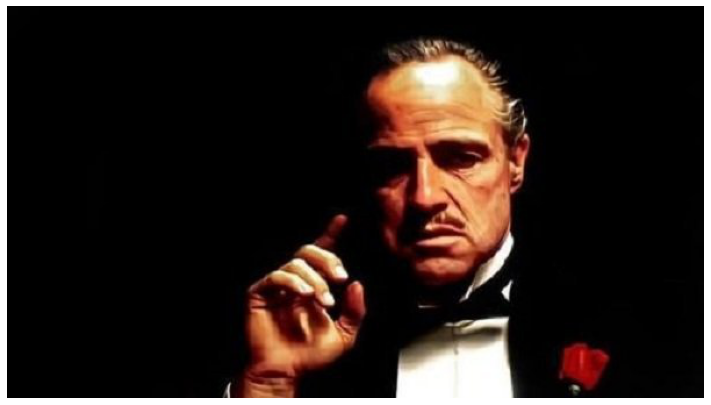

In [3]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(data[10][0])
plt.show()

#### Setting image dimensions

In [4]:
ALPHA = 1
IMAGE_SIZE = 224
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

### Creating features and labels

* Here feature is the image
* The label is the mask
* Images will be stored in "X_train" array
* Masks will be stored in "masks" array

In [5]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
    try:
        img = img[:, :, :3]
    except:
        continue
    X[index] = preprocess_input(np.array(img, dtype = np.float32))
    for i in data[index][1]:
        x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
        x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
        y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [6]:
print(X.shape)
print(masks.shape)

(409, 224, 224, 3)
(409, 224, 224)


#### Loading a sample train image and mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


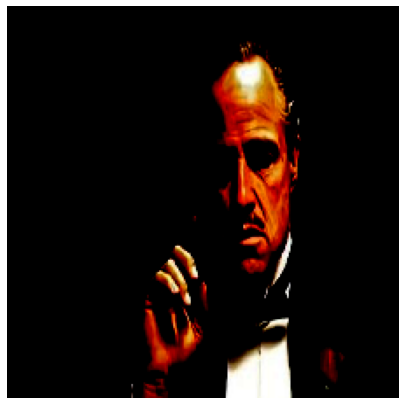

In [7]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(X[n])

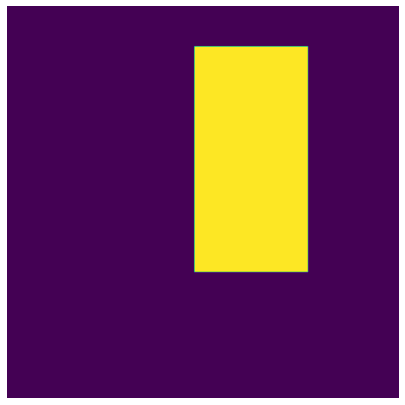

In [8]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(masks[n])

## Creating the model

* Add MobileNet as model with below parameter values
    * input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
    * include_top: False
    * alpha: 1.0
    * weights: "imagenet"
* Add UNET architecture layers

In [9]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable = True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top = False, alpha = ALPHA, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable
    
    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output
    
    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)
    return Model(inputs = model.input, outputs = x)

In [10]:
model = create_model(True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

### Define dice coefficient function

In [11]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define Loss

In [12]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile and train the model

In [13]:
adam = Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = loss, optimizer = adam, metrics = [dice_coefficient])

#### Define checkpoints

In [14]:
checkpoint = ModelCheckpoint('model.h5', monitor = 'val_dice_coefficient', verbose = 1, save_best_only = True, save_weights_only = True, mode = 'max', period = 1)
stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 1e-6, verbose = 1, mode = 'min')

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, masks, test_size = 0.15, random_state = 2019, shuffle = False)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((347, 224, 224, 3), (62, 224, 224, 3), (347, 224, 224), (62, 224, 224))

In [16]:
model.fit(X_train, y_train, 
          epochs = 10, ## increase this figure in case you have sufficient hardware 
          batch_size = 1, 
          callbacks = [checkpoint, reduce_lr, stop], 
          validation_data = (X_valid, y_valid)
         )

Epoch 1/10
347/347 [==============================] - 796s 2s/step - loss: 1.6880 - dice_coefficient: 0.3573 - val_loss: 1.4307 - val_dice_coefficient: 0.4408

Epoch 00001: val_dice_coefficient improved from -inf to 0.44083, saving model to model.h5
Epoch 2/10
347/347 [==============================] - 816s 2s/step - loss: 1.0975 - dice_coefficient: 0.4901 - val_loss: 1.1590 - val_dice_coefficient: 0.4615

Epoch 00002: val_dice_coefficient improved from 0.44083 to 0.46154, saving model to model.h5
Epoch 3/10
347/347 [==============================] - 816s 2s/step - loss: 0.8413 - dice_coefficient: 0.5813 - val_loss: 1.1256 - val_dice_coefficient: 0.4688

Epoch 00003: val_dice_coefficient improved from 0.46154 to 0.46885, saving model to model.h5
Epoch 4/10
347/347 [==============================] - 817s 2s/step - loss: 0.6513 - dice_coefficient: 0.6448 - val_loss: 0.9540 - val_dice_coefficient: 0.5143

Epoch 00004: val_dice_coefficient improved from 0.46885 to 0.51432, saving model to 

### Get the predicted mask for a sample image

In [ ]:
# Load model weight
WEIGHTS_FILE = "model.h5"
learned_model = create_model()
learned_model.load_weights(WEIGHTS_FILE)

In [309]:
sample_img_path = "Part 1Test Data - Prediction Image.jpeg"

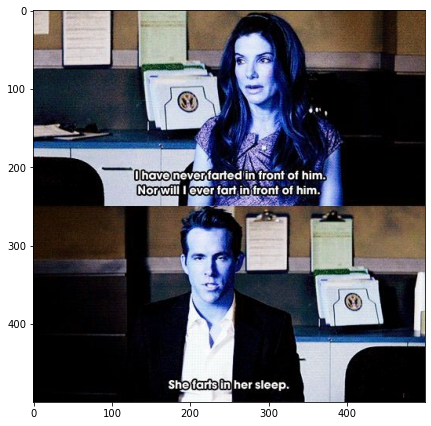

In [310]:
fig = plt.figure(figsize = (15, 7.2))
plt.imshow(sample_image)

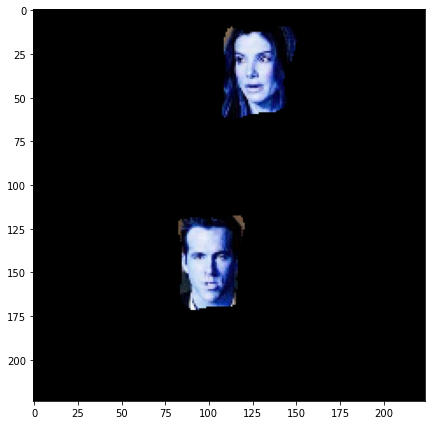

In [345]:
unscaled = cv2.imread(sample_img_path)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(learned_model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2
fig = plt.figure(figsize = (15, 7.2))
plt.imshow(out_image)

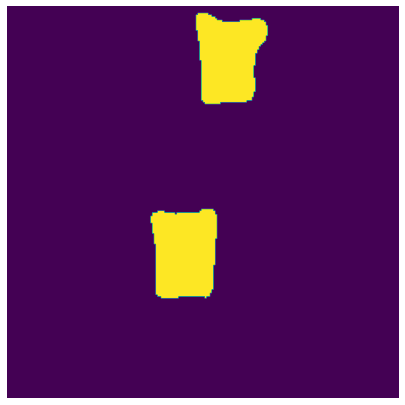

In [339]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)

### Impose the mask on the image

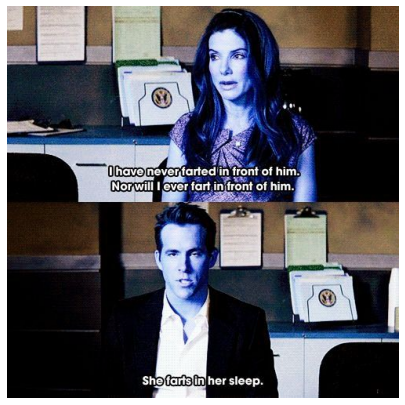

In [341]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(uns)
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

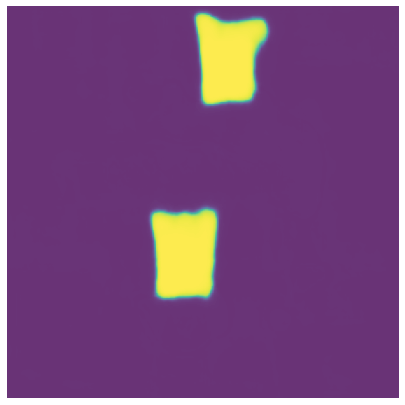

In [342]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(model.predict(x=np.array([feat_scaled]))[0], alpha = 0.8)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

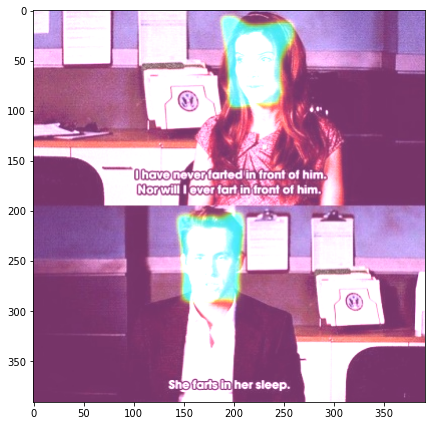

In [344]:
img = cv2.imread('image.jpg', 1)
mask = cv2.imread('mask.jpg', 1)
img = cv2.add(img, mask)
fig = plt.figure(figsize = (15, 7.2))
plt.imshow(img)

## Conclusion
Project was all about how we can make use of a pretrained MobileNet (Transfer Learning) and on top of it add all the UNET layers to train, fit and evaluate model with an objective to predict the boundaries(mask) around the face in a given image.

* Model was complied using binary cross entropy as loss, adam optimizer and dice coefficient as metrics.
* Model checkpoint, early stopping and learning rate reducers were used as callbacks.
* Data was split into train and validation using 85/15 ratio. Best loss I got is 0.26 and dice coeff of 0.84 on the training data.
* Model weights for this were used and then used to predict on validation data to get mask.
* Further checked on sample image and imposed mask on the image.
* As seen in the above image, model does a very good job in predicting the masks.